In [1]:
import os
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.optimizers import Adam
# Function to load and preprocess dataset
def load_dataset(dataset_path, target_size=(224, 224)):
    data = []
    labels = []
    class_names = []
    # Loop through class folders
    for class_name in os.listdir(dataset_path):
        class_folder = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_folder):
            class_names.append(class_name)
            class_index = len(class_names) - 1
            # Loop through images in class folder
            for image_name in os.listdir(class_folder):
                image_path = os.path.join(class_folder, image_name)
                try:
                    image = Image.open(image_path).convert('RGB')  # Ensure RGB
                    image = image.resize(target_size)  # Resize to target size
                    image_array = np.array(image)
                    data.append(image_array)
                    labels.append(class_index)
                except Exception as e:
                    print(f"Error loading image {image_path}: {e}")
    
    return np.array(data), np.array(labels), class_names

# Path to dataset
dataset_path = "/kaggle/input/leaf-images/300_dataset"


In [2]:
# Load and preprocess dataset
data, labels, class_names = load_dataset(dataset_path)
data = preprocess_input(data)  
labels = to_categorical(labels, num_classes=len(class_names))  # One-hot encode labels


Error loading image /kaggle/input/leaf-images/300_dataset/Vad/301.jpg: cannot identify image file '/kaggle/input/leaf-images/300_dataset/Vad/301.jpg'
Error loading image /kaggle/input/leaf-images/300_dataset/Sonmohar/301.jpg: cannot identify image file '/kaggle/input/leaf-images/300_dataset/Sonmohar/301.jpg'
Error loading image /kaggle/input/leaf-images/300_dataset/Vilayati Chinch/301.jpg: cannot identify image file '/kaggle/input/leaf-images/300_dataset/Vilayati Chinch/301.jpg'


In [24]:
# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create a flow for training and testing data
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)


# Initialize the pre-trained DenseNet model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Build the custom model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Global pooling layer
    layers.Dropout(0.5),              # Add dropout for regularization
    layers.Dense(1024, activation='relu'),  # Dense layer with ReLU activation
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')  # Output layer with softmax for multi-class classification
])

In [25]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator,
    steps_per_epoch=(len(X_train) // 32)+1,  # Number of batches per epoch
    epochs=10,  # Adjust number of epochs based on your data
    validation_data=test_generator,
    validation_steps=len(X_test) // 32,  # Number of validation batches
     )


Epoch 1/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 56s 400ms/step - accuracy: 0.1591 - loss: 2.8738 - val_accuracy: 0.6632 - val_loss: 1.3588
Epoch 2/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 28s 333ms/step - accuracy: 0.3441 - loss: 1.9727 - val_accuracy: 0.7500 - val_loss: 0.9699
Epoch 3/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 25s 302ms/step - accuracy: 0.4774 - loss: 1.5606 - val_accuracy: 0.8229 - val_loss: 0.7713
Epoch 4/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 24s 288ms/step - accuracy: 0.5764 - loss: 1.2956 - val_accuracy: 0.9167 - val_loss: 0.4871
Epoch 5/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 26s 308ms/step - accuracy: 0.6068 - loss: 1.1743 - val_accuracy: 0.8698 - val_loss: 0.5350
Epoch 6/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 24s 291ms/step - accuracy: 0.6334 - loss: 1.1198 - val_accuracy: 0.8750 - val_loss: 0.5006
Epoch 7/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 25s 305ms/step - accuracy: 0.6690 - loss: 0.9887 - val_accuracy: 0.8819 - val_loss: 0.4412
Epoch 8/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 24s 285ms/step - accuracy: 0.6869 - loss: 0.9302 - val_accu

In [26]:
# Save the entire model to a file
model.save("DenseNet121_without_fine.keras")
print("Model saved as DenseNet121.keras")


Model saved as DenseNet121.keras


In [9]:
from tensorflow.keras.models import load_model

# Load the model from the file
model = load_model("models/densenet/DenseNet121_without_fine.keras")
print("Model loaded successfully.")


Model loaded successfully.


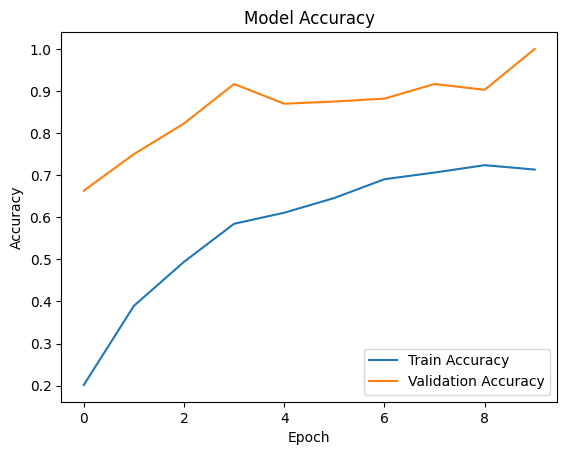

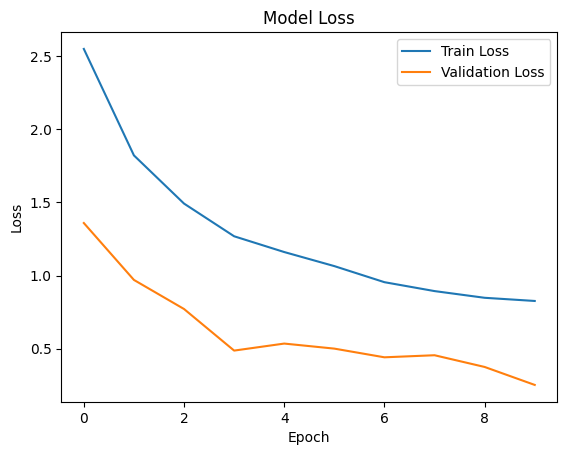

In [27]:
# You can also visualize the training history (optional)
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

In [28]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(X_test) // 32)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9084 - loss: 0.3340
Test Loss: 0.3493930399417877
Test Accuracy: 0.9010416865348816


In [30]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 315ms/step - accuracy: 0.9122 - loss: 0.3327
Test Accuracy: 90.17%


In [33]:
y_pred_probs = model.predict(X_test)  # Probabilities
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Predicted classes
y_true_classes = np.argmax(y_test, axis=1)  # True labels

19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 491ms/step


In [34]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


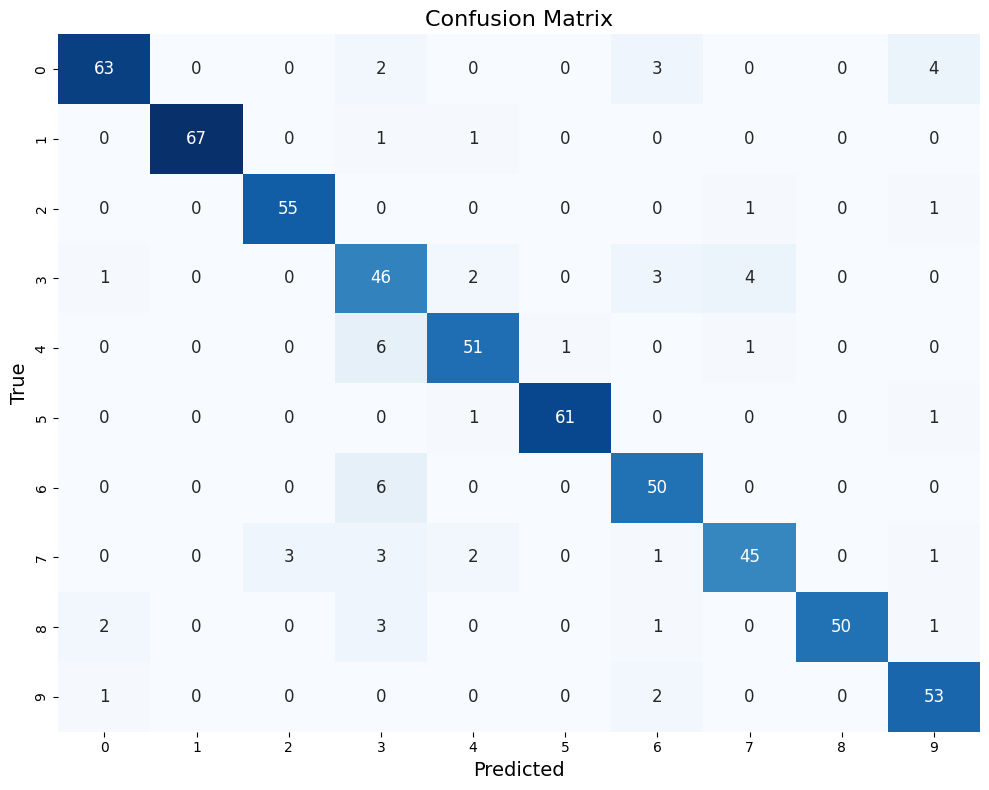

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming your y_true_classes and y_pred_classes are already defined
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Manually define the class labels or infer them from your data
class_labels = np.unique(y_true_classes)  # or define manually like ['class1', 'class2', ...]

# Create a heatmap using seaborn with a blue color palette
plt.figure(figsize=(10, 8))  # Increase the figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, 
            yticklabels=class_labels, cbar=False, annot_kws={"size": 12})  # Adjust font size

# Add labels and title
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)

# Adjust layout to ensure everything fits
plt.tight_layout()

plt.show()


Classification Report:
                     precision    recall  f1-score   support

               Vad       0.94      0.88      0.91        72
Indian Rubber Tree       1.00      0.97      0.99        69
          Sonmohar       0.95      0.96      0.96        57
   Vilayati Chinch       0.69      0.82      0.75        56
           Nilgiri       0.89      0.86      0.88        59
        Sita Ashok       0.98      0.97      0.98        63
              Apta       0.83      0.89      0.86        56
            Kashid       0.88      0.82      0.85        55
            Karanj       1.00      0.88      0.93        57
            Pimpal       0.87      0.95      0.91        56

          accuracy                           0.90       600
         macro avg       0.90      0.90      0.90       600
      weighted avg       0.91      0.90      0.90       600



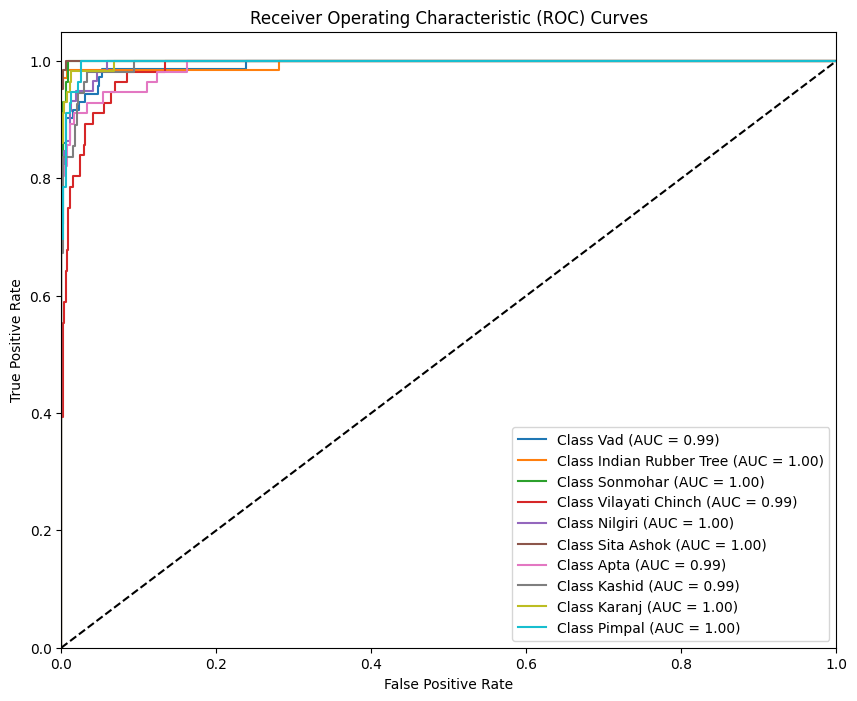

Macro-Average AUC: 1.00


In [36]:
# Precision, Recall, F1-score
report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
print("Classification Report:\n", report)
# ROC and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()

# Macro-Average ROC and AUC
fpr_macro, tpr_macro, _ = roc_curve(y_test.ravel(), y_pred_probs.ravel())
roc_auc_macro = auc(fpr_macro, tpr_macro)

print(f"Macro-Average AUC: {roc_auc_macro:.2f}")


In [37]:
# Unfreeze the base model
base_model.trainable = True

# Recompile the model with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune the model
history_fine = model.fit(
    train_generator,
    steps_per_epoch=(len(X_train) // 32)+1,  # Number of batches per epoch
    epochs=10,  # Adjust number of epochs based on your data
    validation_data=test_generator,
    validation_steps=len(X_test) // 32,  # Number of validation batches
)

Epoch 1/10
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.5976 - loss: 1.2411

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


76/76 ━━━━━━━━━━━━━━━━━━━━ 170s 429ms/step - accuracy: 0.5982 - loss: 1.2388 - val_accuracy: 0.9323 - val_loss: 0.2769
Epoch 2/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 30s 360ms/step - accuracy: 0.7498 - loss: 0.7486 - val_accuracy: 0.9583 - val_loss: 0.2268
Epoch 3/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 28s 334ms/step - accuracy: 0.8381 - loss: 0.5197 - val_accuracy: 0.9566 - val_loss: 0.1858
Epoch 4/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 27s 316ms/step - accuracy: 0.8299 - loss: 0.5273 - val_accuracy: 0.9167 - val_loss: 0.2556
Epoch 5/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 28s 340ms/step - accuracy: 0.8712 - loss: 0.4153 - val_accuracy: 0.9653 - val_loss: 0.1436
Epoch 6/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 28s 331ms/step - accuracy: 0.8742 - loss: 0.4047 - val_accuracy: 1.0000 - val_loss: 0.1197
Epoch 7/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 29s 343ms/step - accuracy: 0.8923 - loss: 0.3318 - val_accuracy: 0.9705 - val_loss: 0.1161
Epoch 8/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 27s 327ms/step - accuracy: 0.9134 - loss: 0.2844 - val_accuracy: 1.00

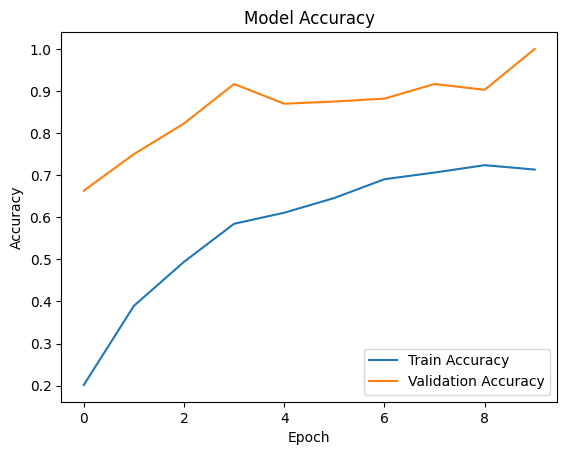

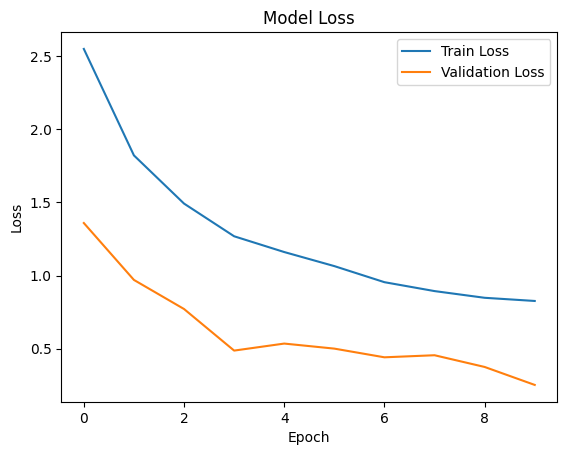

In [38]:
# You can also visualize the training history (optional)
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

In [39]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(X_test) // 32)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.9690 - loss: 0.1175
Test Loss: 0.09423059970140457
Test Accuracy: 0.9774305820465088


In [40]:
y_pred_probs = model.predict(X_test)  # Probabilities
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Predicted classes
y_true_classes = np.argmax(y_test, axis=1)  # True labels


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 444ms/step


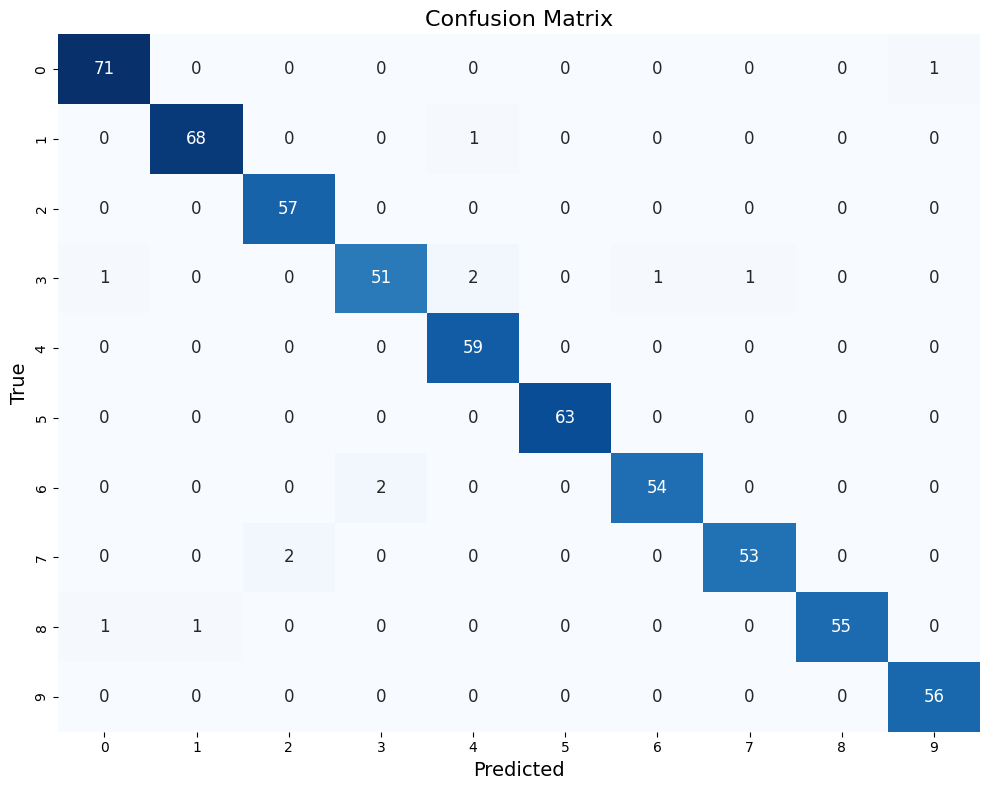

In [41]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming your y_true_classes and y_pred_classes are already defined
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Manually define the class labels or infer them from your data
class_labels = np.unique(y_true_classes)  # or define manually like ['class1', 'class2', ...]

# Create a heatmap using seaborn with a blue color palette
plt.figure(figsize=(10, 8))  # Increase the figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, 
            yticklabels=class_labels, cbar=False, annot_kws={"size": 12})  # Adjust font size

# Add labels and title
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)

# Adjust layout to ensure everything fits
plt.tight_layout()

plt.show()


Classification Report:
                     precision    recall  f1-score   support

               Vad       0.97      0.99      0.98        72
Indian Rubber Tree       0.99      0.99      0.99        69
          Sonmohar       0.97      1.00      0.98        57
   Vilayati Chinch       0.96      0.91      0.94        56
           Nilgiri       0.95      1.00      0.98        59
        Sita Ashok       1.00      1.00      1.00        63
              Apta       0.98      0.96      0.97        56
            Kashid       0.98      0.96      0.97        55
            Karanj       1.00      0.96      0.98        57
            Pimpal       0.98      1.00      0.99        56

          accuracy                           0.98       600
         macro avg       0.98      0.98      0.98       600
      weighted avg       0.98      0.98      0.98       600



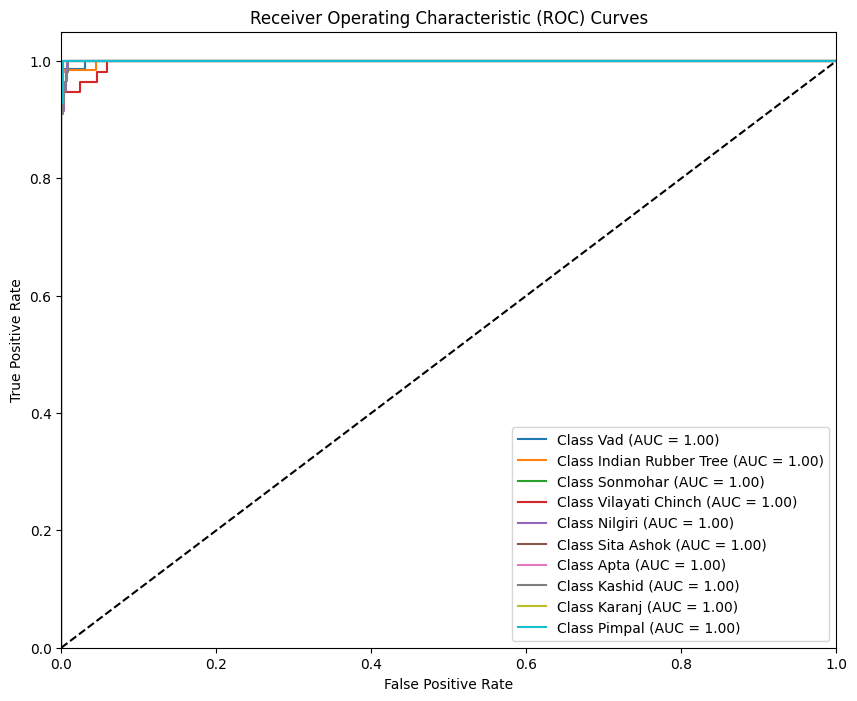

Macro-Average AUC: 1.00


In [42]:
# Precision, Recall, F1-score
report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
print("Classification Report:\n", report)
# ROC and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()

# Macro-Average ROC and AUC
fpr_macro, tpr_macro, _ = roc_curve(y_test.ravel(), y_pred_probs.ravel())
roc_auc_macro = auc(fpr_macro, tpr_macro)

print(f"Macro-Average AUC: {roc_auc_macro:.2f}")
